In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [19]:
import os
from bs4 import BeautifulSoup
from src.utils.data import create_dataset, split_metadata
from src.utils.data import xml_to_dataframe
from train import create_model

dataset_path = '../data/processed/dataset'
annotations_path = os.path.join(dataset_path, 'annotations.xml')
images_path = os.path.join(dataset_path, 'images')

with open(annotations_path, 'rb') as f:
    annotations = BeautifulSoup(f.read(), 'xml')

df = xml_to_dataframe(annotations)
df['file_path'] = images_path + '/' + df['file_name']


# Split the data to train and test
train_images, valid_images, test_images = split_metadata(df, train_frac=0.7, valid_frac=0.15)

# Create datasets
ds_train = create_dataset(train_images)
ds_valid = create_dataset(valid_images)
ds_test = create_dataset(test_images)

# Create model
model = create_model()

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                           

: 

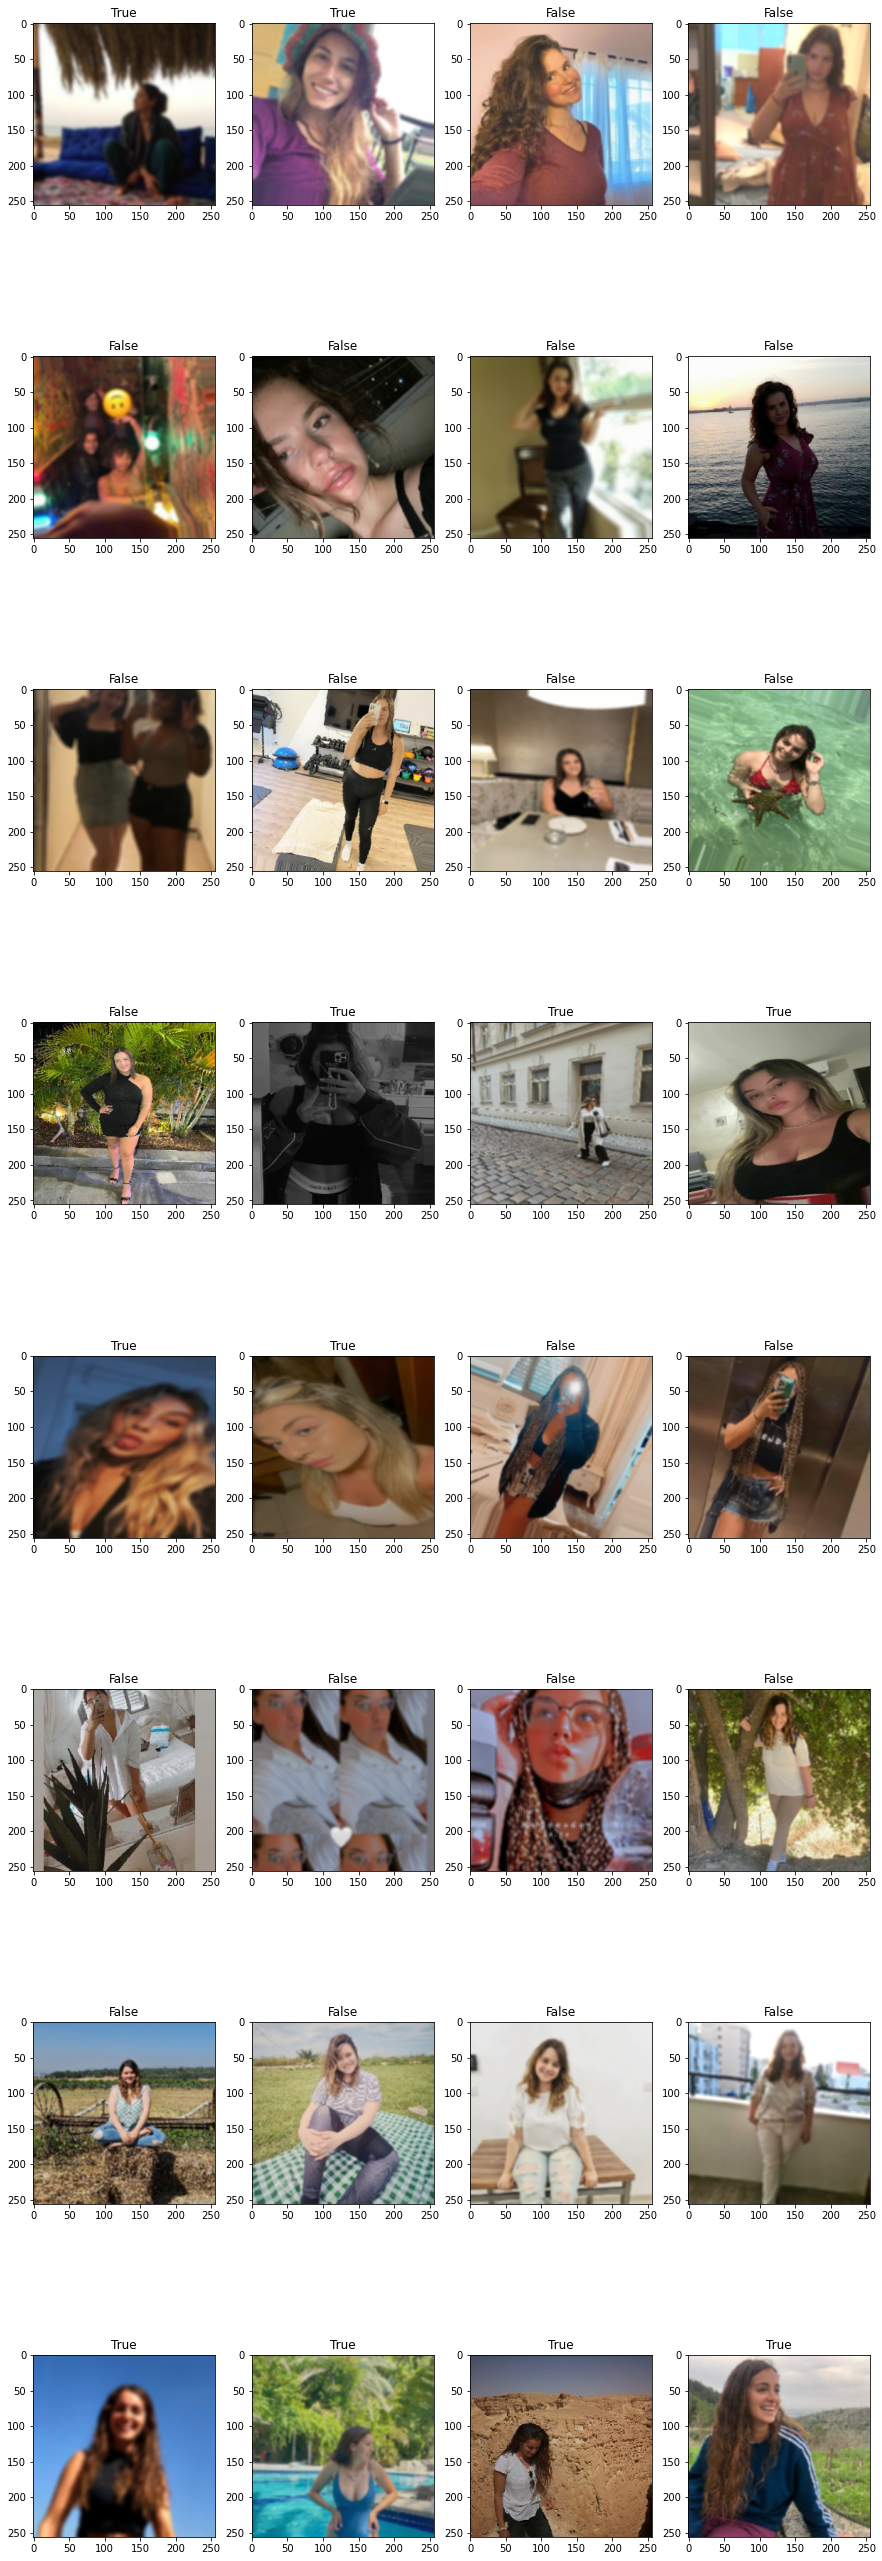

In [16]:
import matplotlib.pyplot as plt

iterator = iter(ds_valid)
batch = next(iterator)
images, labels = batch

n_rows, n_cols = 8, 4
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 6))

counter = 0
for i in range(n_rows):
    for j in range(n_cols):
        ax[i, j].imshow(images[counter])
        ax[i, j].set_title(labels[counter].numpy())
        counter += 1